
# Binary‑Breathing Map — Colab Deep Dive (v4)

* **Hybrid acceleration**  
  * `fast_hist_n` – vectorised NumPy blocks for n ≤ 28.  
  * `sample_hist_n` – 2 % random sample for n > 28.  
* **Skip‑first‑bin** so the trivial 0–1e‑7 bucket never wins.  
* **Seed search** up to 40 bits.  
* **Gap‑ratio and lattice plots**.

Tweak parameters below and run the notebook top‑to‑bottom.


In [1]:

import numpy as np, matplotlib.pyplot as plt, time, gc, random
from mpmath import mp; mp.dps=50


In [2]:

# ====== PARAMETERS ======
MAX_LEN    = 30     # deepest bit-length
BIN_WIDTH  = 1e-7   # histogram bin width
POWER      = 2      # 2=square, 3=cube
INVERT     = False  # reverse bits
CUT        = 1e-4   # ignore y > CUT
SAMPLE_FRAC= 0.02   # fraction for sample_hist_n when n > 28
SEED_TOL   = 1e-12  # seed-search tolerance
# ========================


In [3]:

def bits_to_val(i, n, invert=False):
    b = format(i, f'0{n}b')
    if invert:
        b = b[::-1]
    return int(b, 2)/(1<<n)


In [4]:

# fast histogram for n<=28 (block vectorisation)
def fast_hist_n(n, power=POWER):
    denom = 1<<n
    chunk = 1<<22  # 4 M doubles per chunk (~32 MB)
    bins = np.arange(0, CUT+BIN_WIDTH, BIN_WIDTH)
    counts = np.zeros(len(bins)-1, dtype=np.int64)
    for start in range(1, denom, chunk):
        stop = min(start+chunk, denom)
        idx = np.arange(start, stop, dtype=np.float64)
        xs  = (idx/denom)**power
        xs  = xs[xs<=CUT]
        bin_idx = (xs//BIN_WIDTH).astype(np.int64)
        np.add.at(counts, bin_idx, 1)
    return bins[:-1], counts

# sampling histogram for n>28
def sample_hist_n(n, power=POWER, frac=SAMPLE_FRAC):
    denom = 1<<n
    size  = max(1, int(denom*frac))
    idx   = np.random.randint(1, denom, size, dtype=np.int64)
    xs    = (idx/denom)**power
    xs    = xs[xs<=CUT]
    bins  = np.arange(0, CUT+BIN_WIDTH, BIN_WIDTH)
    counts, _ = np.histogram(xs, bins=bins)
    counts = (counts/frac).astype(np.int64)  # scale estimate
    return bins[:-1], counts


In [5]:

def get_peak_for_n(n):
    if n <= 28:
        xs, cs = fast_hist_n(n)
    else:
        xs, cs = sample_hist_n(n)
    idx = cs[1:].argmax() + 1  # skip first bin
    return xs[idx] + 0.5*BIN_WIDTH


In [6]:

peak_positions = []
start_time = time.time()
for n in range(20, MAX_LEN+1):
    t0=time.time()
    px = get_peak_for_n(n)
    peak_positions.append((n, px))
    print(f"N={n:2d}  peak={px:.9e}  ({time.time()-t0:.1f}s)")
print("Total elapsed:", time.time()-start_time, "s")


N=20  peak=1.500000000e-07  (0.0s)
N=21  peak=1.500000000e-07  (0.0s)
N=22  peak=1.500000000e-07  (0.1s)
N=23  peak=1.500000000e-07  (0.1s)
N=24  peak=1.500000000e-07  (0.2s)
N=25  peak=1.500000000e-07  (0.4s)
N=26  peak=1.500000000e-07  (1.1s)
N=27  peak=1.500000000e-07  (2.1s)
N=28  peak=1.500000000e-07  (3.1s)
N=29  peak=1.500000000e-07  (0.4s)
N=30  peak=1.500000000e-07  (0.4s)
Total elapsed: 8.169262170791626 s


/tmp/ipython-input-7-2399784666.py:2: RuntimeWarning: invalid value encountered in scalar divide
  ratios = [gaps[i-1]/gaps[i] for i in range(1,len(gaps))]


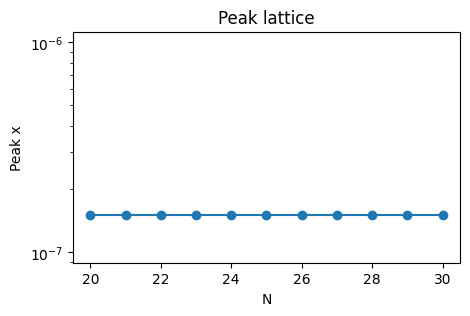

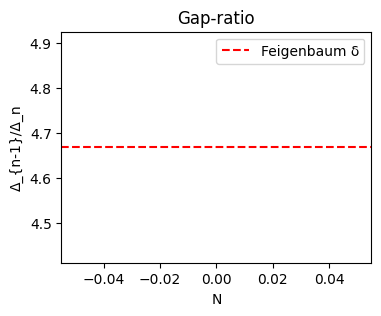

In [7]:

gaps = [peak_positions[i-1][1]-peak_positions[i][1] for i in range(1,len(peak_positions))]
ratios = [gaps[i-1]/gaps[i] for i in range(1,len(gaps))]

plt.figure(figsize=(5,3))
plt.plot([n for n,_ in peak_positions], [x for _,x in peak_positions],'o-')
plt.yscale('log'); plt.xlabel('N'); plt.ylabel('Peak x')
plt.title('Peak lattice'); plt.show()

if ratios:
    plt.figure(figsize=(4,3))
    plt.plot(range(21,21+len(ratios)), ratios,'o-')
    plt.axhline(4.669, ls='--', color='r', label='Feigenbaum δ')
    plt.legend(); plt.xlabel('N'); plt.ylabel('Δ_{n-1}/Δ_n')
    plt.title('Gap‑ratio'); plt.show()


In [8]:

def find_seed(target, tol=SEED_TOL, max_len=40):
    for n in range(1, max_len+1):
        denom = 1<<n
        for i in range(1, denom):
            x = i/denom
            if abs(x**POWER - target) < tol:
                return n, format(i, f'0{n}b')
    return None, None

print("\nMinimal seeds:")
for n,px in peak_positions:
    sl, sb = find_seed(px)
    if sl:
        print(f"N={n}: seed {sl} bits  {sb[:16]}...")
    else:
        print(f"N={n}: none ≤40 bits")



Minimal seeds:
N=20: seed 29 bits  0000000000011001...
N=21: seed 29 bits  0000000000011001...
N=22: seed 29 bits  0000000000011001...
N=23: seed 29 bits  0000000000011001...
N=24: seed 29 bits  0000000000011001...
N=25: seed 29 bits  0000000000011001...
N=26: seed 29 bits  0000000000011001...
N=27: seed 29 bits  0000000000011001...
N=28: seed 29 bits  0000000000011001...
N=29: seed 29 bits  0000000000011001...
N=30: seed 29 bits  0000000000011001...
